# TODO


Q5 + Q6 + Q7 + Q10
![](./image/ComputationalSimilarityTemplate.png)



The task look like this:

![](./image/Snipaste_2025-07-20_21-47-40.png)

# **Q5**

In [201]:
import os
import sys
import json
import numpy as np
import torch as th
import matplotlib.pyplot as plt

import motornet as mn
from motornet.effector import RigidTendonArm26
from motornet.muscle import MujocoHillMuscle
# from ctd.task_modeling.task_env.random_target import RandomTarget  # ! use random_target.py didn't task_env.py 

# rt_task_env = RandomTarget(effector = RigidTendonArm26(muscle = MujocoHillMuscle()))#.cuda()

# use predefined class module
from ctd.task_modeling.model.rnn import GRU_RNN
from ctd.task_modeling.datamodule.task_datamodule import TaskDataModule
from ctd.task_modeling.task_wrapper.task_wrapper import TaskTrainedWrapper
from pytorch_lightning import Trainer

# rnn = GRU_RNN(latent_size = 128,device ="cuda")
# # rnn.cuda()
# task_env = rt_task_env
# # task_env.cuda()
# task_datamodule = TaskDataModule(task_env, n_samples = 1000, batch_size = 256)
# task_wrapper = TaskTrainedWrapper(learning_rate=1e-3, weight_decay = 1e-8)

# rnn.init_model(
#     input_size = task_env.observation_space.shape[0] + task_env.context_inputs.shape[0],
#     output_size = task_env.action_space.shape[0]
#     )

# task_wrapper.set_environment(task_env)
# task_wrapper.set_model(rnn)


In [354]:
effector = RigidTendonArm26(muscle = MujocoHillMuscle())
env = mn.environment.RandomTargetReach(effector=effector, max_ep_duration=1.)

class Policy(th.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, device):
        super().__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.n_layers = 1
        
        self.gru = th.nn.GRU(input_dim, hidden_dim, 1, batch_first=True)
        self.fc = th.nn.Linear(hidden_dim, output_dim)
        self.sigmoid = th.nn.Sigmoid()

        # the default initialization in torch isn't ideal
        for name, param in self.named_parameters():
            if name == "gru.weight_ih_l0":
                th.nn.init.xavier_uniform_(param)
            elif name == "gru.weight_hh_l0":
                th.nn.init.orthogonal_(param)
            elif name == "gru.bias_ih_l0":
                th.nn.init.zeros_(param)
            elif name == "gru.bias_hh_l0":
                th.nn.init.zeros_(param)
            elif name == "fc.weight":
                th.nn.init.xavier_uniform_(param)
            elif name == "fc.bias":
                th.nn.init.constant_(param, -5.)
            else:
                raise ValueError
        
        self.to(device)

    def forward(self, x, h0):
        y, h = self.gru(x[:, None, :], h0)
        u = self.sigmoid(self.fc(y)).squeeze(dim=1)
        return u, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device)
        return hidden
    
device = th.device("cpu")

policy = Policy(env.observation_space.shape[0], 128, env.n_muscles, device=device)
optimizer = th.optim.Adam(policy.parameters(), lr=10**-3)

In [ ]:
batch_size = 32
n_batch = 6000
losses = []
interval = 250

def l1(x, y):
  """L1 loss"""
  return th.mean(th.sum(th.abs(x - y), dim=-1))

def l2(x, y):
  """L2 loss"""
  return th.mean(th.sum((x - y).pow(2), dim=-1))

for batch in range(n_batch):
  # initialize batch
  h = policy.init_hidden(batch_size=batch_size)
  obs, info = env.reset(options={"batch_size": batch_size})
  terminated = False

  # initial positions and targets
  xy = [info["states"]["fingertip"][:, None, :]]
  tg = [info["goal"][:, None, :]]

  # simulate whole episode
  while not terminated:  # will run until `max_ep_duration` is reached
    action, h = policy(obs, h)
    obs, reward, terminated, truncated, info = env.step(action=action)

    xy.append(info["states"]["fingertip"][:, None, :])  # trajectories
    tg.append(info["goal"][:, None, :])  # targets

  # concatenate into a (batch_size, n_timesteps, xy) tensor
  xy = th.cat(xy, axis=1)
  tg = th.cat(tg, axis=1)
  loss = l2(xy, tg)  # L1 loss on position
  # break
  # backward pass & update weights
  optimizer.zero_grad() 
  loss.backward()
  th.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.)  # important!
  optimizer.step()
  losses.append(loss.item())

  if (batch % interval == 0) and (batch != 0):
    print("Batch {}/{} Done, mean policy loss: {}".format(batch, n_batch, sum(losses[-interval:])/interval))


### Perform of task

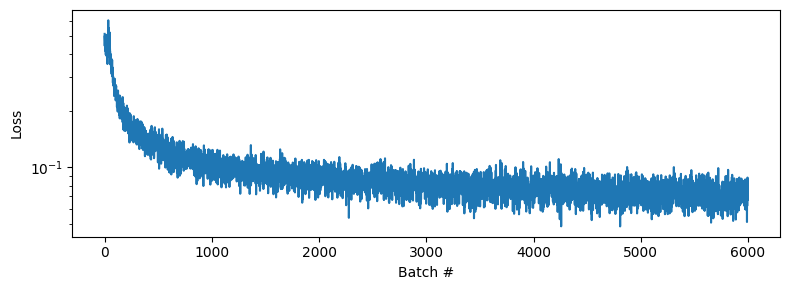

In [180]:
with open(os.path.join("save", "log.json"), 'r') as file:
    log = json.load(file)

def plot_training_log(log):
  fig, axs = plt.subplots(1, 1)
  fig.set_tight_layout(True)
  fig.set_size_inches((8, 3))

  axs.semilogy(log)

  axs.set_ylabel("Loss")
  axs.set_xlabel("Batch #")
  plt.show()

# plot_training_log(losses)
plot_training_log(log)

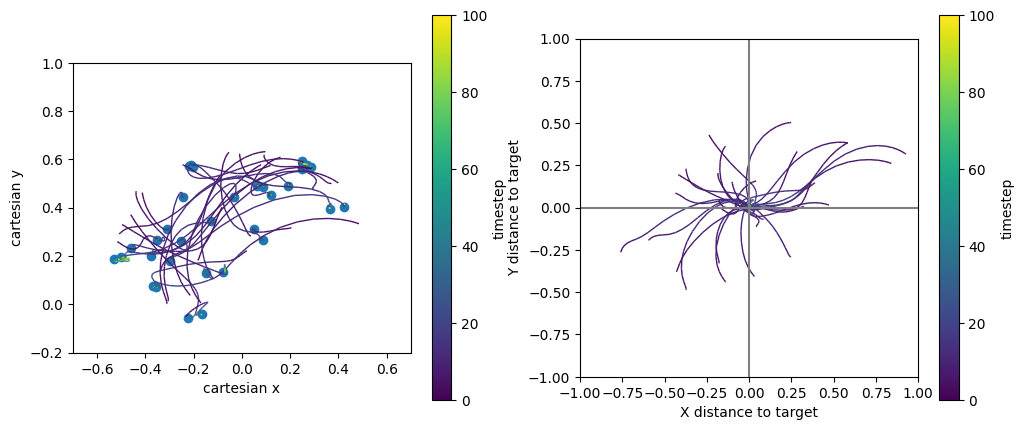

In [268]:
plotor = mn.plotor.plot_pos_over_time

def plot_simulations(xy, target_xy):
  target_x = target_xy[:, -1, 0]
  target_y = target_xy[:, -1, 1]

  plt.figure(figsize=(12,5))

  plt.subplot(1,2,1)
  plt.ylim([-0.2, 1])
  plt.xlim([-0.7, 0.7])
  plotor(axis=plt.gca(), cart_results=xy)
  plt.scatter(target_x, target_y)

  plt.subplot(1,2,2)
  plt.ylim([-1, 1])
  plt.xlim([-1, 1])
  plotor(axis=plt.gca(), cart_results=xy - target_xy)
  plt.axhline(0, c="grey")
  plt.axvline(0, c="grey")
  plt.xlabel("X distance to target")
  plt.ylabel("Y distance to target")
  plt.show()


plot_simulations(xy=th.detach(xy), target_xy=th.detach(tg))

In [45]:
# save

weight_file = os.path.join("save", "weights")
log_file = os.path.join("save", "log.json")
cfg_file = os.path.join("save", "cfg.json")


# save model weights
th.save(policy.state_dict(), weight_file)


# save training history (log)
with open(log_file, 'w') as file:
  json.dump(losses, file)


# save environment configuration dictionary
cfg = env.get_save_config()
with open(cfg_file, 'w') as file:
  json.dump(cfg, file)


print("done.")

done.


In [355]:
# load and test

with open(cfg_file, 'r') as file:
    cfg = json.load(file)


for k1, v1 in cfg.items():
  if isinstance(v1, dict):
    print(k1 + ":")
    for k2, v2 in v1.items():
      if type(v2) is dict:
        print("\t\t" + k2 + ":")
        for k3, v3 in v2.items():
          print("\t\t\t\t" + k3 + ": ", v3)
      else:
        print("\t\t" + k2 + ": ", v2)
  else:
    print(k1 + ": ", v1)

with open(log_file, 'r') as file:
    loaded_training_log = json.load(file)

env = mn.environment.RandomTargetReach(effector=mn.effector.RigidTendonArm26(muscle = MujocoHillMuscle()), max_ep_duration=1.)
policy = Policy(env.observation_space.shape[0], 128, env.n_muscles, device=device)

policy.load_state_dict(th.load(weight_file))

name:  Env
T_destination:  ~T_destination
action_frame_stacking:  0
action_noise:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
call_super_init:  False
delay_range:  [0, 0]
device:  cpu
differentiable:  True
dt:  0.01
dump_patches:  False
elapsed:  1.0000000000000007
max_ep_duration:  1.0
metadata:
		render_modes:  []
n_muscles:  6
np_random_seed:  33922504622489984084375893056255576056
nq_init:  None
obs_noise:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
proprioception_delay:  1
proprioception_noise:  [0.0]
q_init:  None
render_mode:  None
seed:  None
space_dim:  2
spec:  None
training:  True
vision_delay:  1
vision_noise:  [0.0]
effector:
		muscle:
				name:  MujocoHillMuscle
				state names:  ['activation', 'muscle length', 'muscle velocity', 'force-length PE', 'force-length CE', 'force-velocity CE', 'force']
		skeleton:
				dof:  2
				dt:  0.01
				space_dim:  2
				I1:  0.051
				I2:  0.057
				L1:  0.309
				L2:  0.333
				L1g:  0.135
				L2g:  0.165
				

<All keys matched successfully>

## **RigidTendonArm26**

pre-built effector class, 6-muscles, “lumped-muscle” model from (_[1] Nijhof, E.-J., & Kouwenhoven, E. Simulation of Multijoint Arm Movements (2000). In J. M. Winters & P. E. Crago, Biomechanics and Neural Control of Posture and Movement (pp. 363–372). Springer New York. doi: 10.1007/978-1-4612-2104-3_29_)

- muscle define:
    the model muscle use MujocoHillMuscle
    - timeconst: 
      Muscles are composed of slow-twitch and fast-twitch fibers. The typical muscle is mixed, but some muscles have a higher proportion of one or the other fiber type, making them faster or slower. This can be modeled by adjusting the time constants. The vmax parameter of the FLV function should also be adjusted accordingly.  use in class motornet.muscle.Muscle integrate Ordinary Differential Equation.
- skeletion define:
    default use TwoDofArm ，A two degrees-of-freedom planar arm. Defines the center of mass, weight, inertia and length of the two bones


## **MujocoHillMuscle**

pre-built class is Hill-type muscle model.





### other try

In [18]:
task_wrapper # task and model

TaskTrainedWrapper(
  (task_env): RandomTarget(
    (effector): RigidTendonArm26(
      (skeleton): TwoDofArm()
      (muscle): MujocoHillMuscle()
    )
  )
  (model): GRU_RNN(
    (cell): GRUCell(17, 128)
    (readout): Linear(in_features=128, out_features=6, bias=True)
  )
)

In [19]:
'''
defined dataset like this

class xxxDataset(pytorch_lightning.LightningDataModule): 
    def __init__(self, ): 
        pass 
    def train_dataloader(self) -> torch.utils.DataLoader: 
        pass 
    def val_dataloader(self) -> torch.utils.DataLoader: 
        pass
'''

task_datamodule # dataset

In [24]:
trainer = Trainer(accelerator= "cpu",log_every_n_steps=100,max_epochs=500,enable_progress_bar=True)
# 

trainer.fit(task_wrapper, task_datamodule)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type         | Params | Mode 
--------------------------------------------------
0 | task_env | RandomTarget | 84     | train
1 | model    | GRU_RNN      | 57.4 K | train
--------------------------------------------------
57.4 K    Trainable params
84        Non-trainable params
57.4 K    Total params
0.230     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 4/4 [00:06<00:00,  0.63it/s, v_num=0]          

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 4/4 [00:06<00:00,  0.63it/s, v_num=0]


## **RandomTarget task define**

Inherited from `motornet.environment` class,  environment will define:
- initial joint states 
- proprioception_delay & Vision_delay: the delay in seconds for the proprioceptive/visual feedback 
- proprioception_noise & Vision_noise: the standard deviation of the Gaussian noise added

input has 3 labels : ["TargetX", "TargetY", "GoCue"]

output has 6 labels :  ["Pec", "Delt", "Brad", "TriLong", "Biceps", "TriLat"]

loss fuction : MSELOSS()




# **Q6**

In [278]:
print(info.keys())
info["states"]["geometry"].shape

dict_keys(['states', 'action', 'noisy action', 'goal'])


torch.Size([32, 4, 6])

In [295]:
from ctd.comparison.analysis.tt.tasks import tt_RandomTarget
# Create the analysis object:

fpath_RT = "lightning_logs/version_0"
analysis_tt_RT = TT_RandomTargetDelay(
    run_name = "RandomTarget_trained", 
    filepath = fpath_RT)

ModuleNotFoundError: No module named 'DSA'

# **Q7**

The force task definition observed in an example: 
`ff_task = mn.task.FixedForceField(n_steps=100, force_magnitude=1.0, force_direction=np.array([-1, 0]))`
However, mn.task is written in version 0.1.5, which does not have this at present, and the `FixedForceField` class is not found in the 0.1.5 version program. There is a `RandomTargetReachWithLoads` class, which describes adding bookmarks to the skeleton endpoint. The 0.2.0 version document does not have a corresponding class, so consider writing one based on the writing method.

Note that the writing method of notification has been migrated to the Skeleton class, and the `ode` built-in function has the following attributes:

在一个示例中观察到的加力任务定义：
`ff_task = mn.task.FixedForceField(n_steps=100, force_magnitude=1.0, force_direction=np.array([-1, 0]))`
但是，mn.task 是 0.1.5 版本的写法，目前没有这个，而且在0.1.5 版本程序中也未发现 `FixedForceField` class，有 `RandomTargetReachWithLoads` class, 描述是在 skeletion 端点加载荷。 0.2.0 版本的文档没有对应的class，考虑参考写法写一个。

注意到载荷的写法迁移到 Skeleton 类中了, `ode` 内置函数具有属性：

- endpoint_load – Tensor, the loads applied to the skeleton’s endpoint. The dimensionality should match the skeleton object or subclass’ space_dim attribute.



In [370]:
def plot_a_(plot=True,batch_size = 32,show=True):
    obs, info = env_force.reset(options={"batch_size": batch_size})
    if show is True:
        print(obs.shape)
        print(info.keys())
        print(info['states'].keys())
        print(info['states']['geometry'].shape)
    else:
        pass
    loss = []
    for batch in range(n_batch):
        h = policy.init_hidden(batch_size=batch_size)
        xy = [info["states"]["fingertip"][:, None, :]]
        tg = [info["goal"][:, None, :]]
        terminated = False

        # simulate whole episode
        while not terminated:  # will run until `max_ep_duration` is reached
            action, h = policy(obs, h)
            obs, reward, terminated, truncated, info = env_force.step(action=action)

            xy.append(info["states"]["fingertip"][:, None, :])  # trajectories
            tg.append(info["goal"][:, None, :])  # targets

        # concatenate into a (batch_size, n_timesteps, xy) tensor
        xy = th.cat(xy, axis=1)
        tg = th.cat(tg, axis=1)
        loss.append(l2(xy, tg))
        break
    
    if plot is True:
        plotor = mn.plotor.plot_pos_over_time
        plot_simulations(xy=th.detach(xy), target_xy=th.detach(tg))

    return loss

### loads on endpoint is 1N

Parameter containing:
tensor([[-1.,  0.]])
torch.Size([32, 16])
dict_keys(['states', 'action', 'noisy action', 'goal'])
dict_keys(['joint', 'cartesian', 'muscle', 'geometry', 'fingertip'])
torch.Size([32, 4, 6])


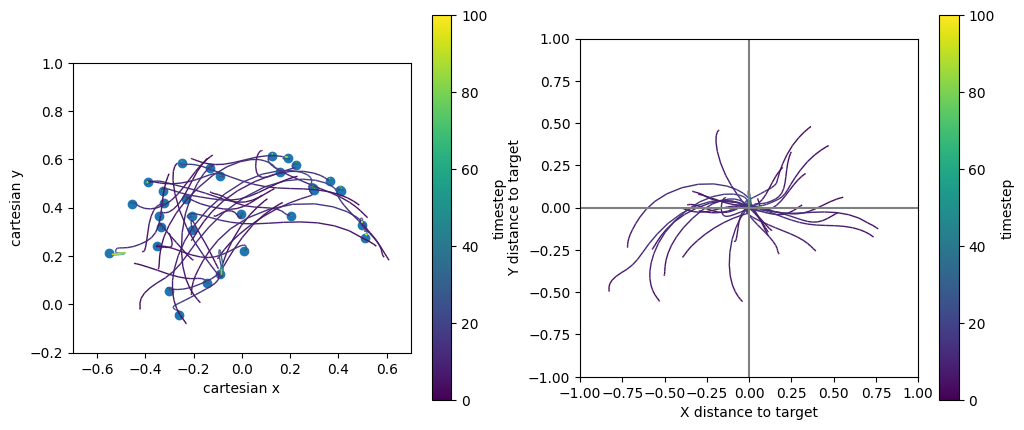

[tensor(0.0232, grad_fn=<MeanBackward0>)]

In [367]:
effector_force = RigidTendonArm26(muscle = MujocoHillMuscle())
effector_force.default_endpoint_load[0,0] = -1   # ? 单位是多少？？？  1N  = ？
# effector_force.default_endpoint_load[0,1] = 1 
# effector_force.default_joint_load[0,0] = 100
print(effector_force.default_endpoint_load)
env_force = mn.environment.RandomTargetReach(effector=effector_force, max_ep_duration=1.)
plot_a_() 

### loads on endpoint is 10N

Parameter containing:
tensor([[-10.,   0.]])
torch.Size([32, 16])
dict_keys(['states', 'action', 'noisy action', 'goal'])
dict_keys(['joint', 'cartesian', 'muscle', 'geometry', 'fingertip'])
torch.Size([32, 4, 6])


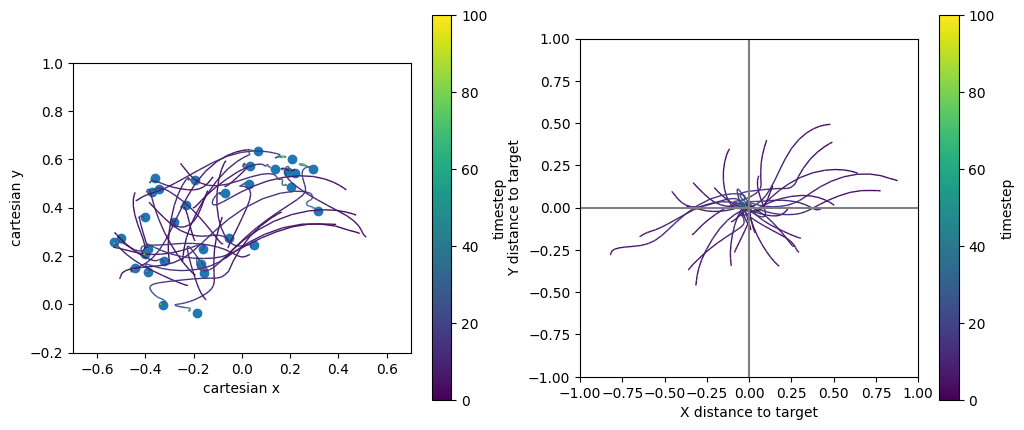

[tensor(0.0190, grad_fn=<MeanBackward0>)]

In [361]:
effector_force.default_endpoint_load[0,0] = -10   
# effector_force.default_endpoint_load[0,1] = 1 
# effector_force.default_joint_load[0,0] = 100
print(effector_force.default_endpoint_load)
env_force = mn.environment.RandomTargetReach(effector=effector_force, max_ep_duration=1.)
plot_a_() # loads on endpoint is 10N

### loads on endpoint is 100N

Parameter containing:
tensor([[-100.,    0.]])
torch.Size([32, 16])
dict_keys(['states', 'action', 'noisy action', 'goal'])
dict_keys(['joint', 'cartesian', 'muscle', 'geometry', 'fingertip'])
torch.Size([32, 4, 6])


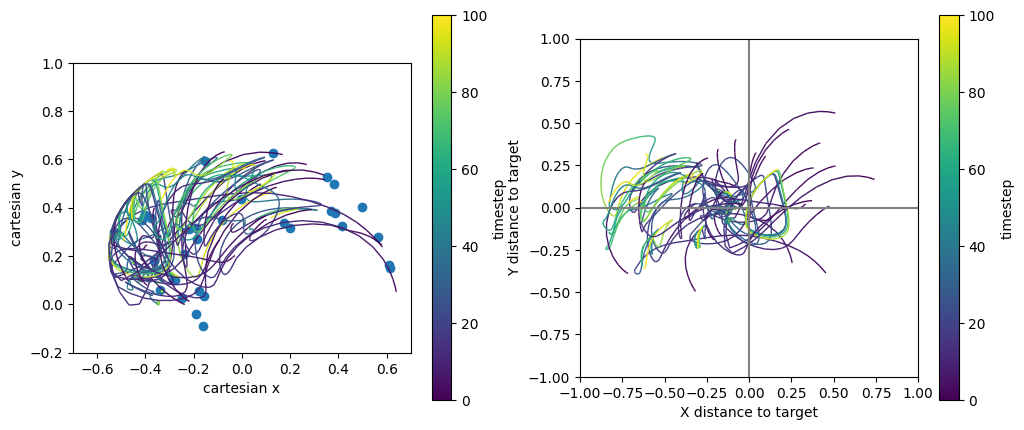

In [ ]:
effector_force.default_endpoint_load[0,0] = -100   
# effector_force.default_endpoint_load[0,1] = 1 
# effector_force.default_joint_load[0,0] = 100
print(effector_force.default_endpoint_load)
env_force = mn.environment.RandomTargetReach(effector=effector_force, max_ep_duration=1.)
plot_a_() # loads on endpoint is 100N

### test MSEloss change

In [369]:
loss_func = []
for i in range(0,100):
    effector_force.default_endpoint_load[0,0] = -1 * i  
    env_force = mn.environment.RandomTargetReach(effector=effector_force, max_ep_duration=1.)
    loss = plot_a_(plot=False,batch_size = 500)[0]
    loss_func.append(loss)

torch.Size([500, 16])
dict_keys(['states', 'action', 'noisy action', 'goal'])
dict_keys(['joint', 'cartesian', 'muscle', 'geometry', 'fingertip'])
torch.Size([500, 4, 6])
torch.Size([500, 16])
dict_keys(['states', 'action', 'noisy action', 'goal'])
dict_keys(['joint', 'cartesian', 'muscle', 'geometry', 'fingertip'])
torch.Size([500, 4, 6])
torch.Size([500, 16])
dict_keys(['states', 'action', 'noisy action', 'goal'])
dict_keys(['joint', 'cartesian', 'muscle', 'geometry', 'fingertip'])
torch.Size([500, 4, 6])
torch.Size([500, 16])
dict_keys(['states', 'action', 'noisy action', 'goal'])
dict_keys(['joint', 'cartesian', 'muscle', 'geometry', 'fingertip'])
torch.Size([500, 4, 6])
torch.Size([500, 16])
dict_keys(['states', 'action', 'noisy action', 'goal'])
dict_keys(['joint', 'cartesian', 'muscle', 'geometry', 'fingertip'])
torch.Size([500, 4, 6])
torch.Size([500, 16])
dict_keys(['states', 'action', 'noisy action', 'goal'])
dict_keys(['joint', 'cartesian', 'muscle', 'geometry', 'fingertip']

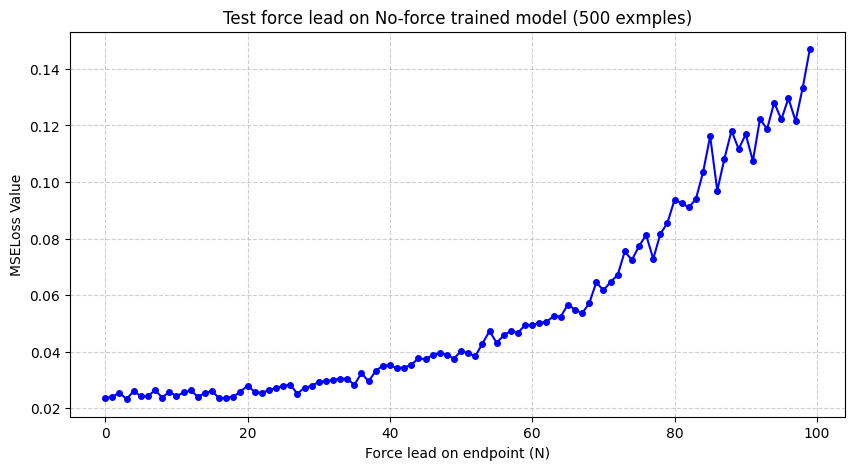

In [391]:
import matplotlib.pyplot as plt
import numpy as np

y_values = [i.item() for i in loss_func]

x_values = range(0, 100) 

plt.figure(figsize=(10, 5))
plt.plot(x_values, y_values, marker='o', linestyle='-', color='blue', markersize=4, linewidth=1.5)

plt.title("Test force lead on No-force trained model (500 exmples)")
plt.xlabel("Force lead on endpoint (N)")
plt.ylabel("MSELoss Value")
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

# **Q10**

In [ ]:
effector_force = RigidTendonArm26(muscle = MujocoHillMuscle())
effector_force.default_endpoint_load[0,0] = -1   
# effector_force.default_endpoint_load[0,1] = 1 
# effector_force.default_joint_load[0,0] = 100
print(effector_force.default_endpoint_load)
env_force = mn.environment.RandomTargetReach(effector=effector_force, max_ep_duration=1.)

# ------------------------------

policy_10 = Policy(env_force.observation_space.shape[0], 128, env_force.n_muscles, device=device)
optimizer = th.optim.Adam(policy.parameters(), lr=10**-3)

batch_size = 32
n_batch = 6000
losses = []
interval = 250

def l1(x, y):
  """L1 loss"""
  return th.mean(th.sum(th.abs(x - y), dim=-1))

def l2(x, y):
  """L2 loss"""
  return th.mean(th.sum((x - y).pow(2), dim=-1))

for batch in range(n_batch):
  # initialize batch
  h = policy_10.init_hidden(batch_size=batch_size)
  obs, info = env_force.reset(options={"batch_size": batch_size})
  terminated = False

  # initial positions and targets
  xy = [info["states"]["fingertip"][:, None, :]]
  tg = [info["goal"][:, None, :]]

  # simulate whole episode
  while not terminated:  # will run until `max_ep_duration` is reached
    action, h = policy_10(obs, h)
    obs, reward, terminated, truncated, info = env_force.step(action=action)

    xy.append(info["states"]["fingertip"][:, None, :])  # trajectories
    tg.append(info["goal"][:, None, :])  # targets

  # concatenate into a (batch_size, n_timesteps, xy) tensor
  xy = th.cat(xy, axis=1)
  tg = th.cat(tg, axis=1)
  # break
  loss = l2(xy, tg)  # L1 loss on position
  
  # backward pass & update weights
  optimizer.zero_grad() 
  loss.backward()
  th.nn.utils.clip_grad_norm_(policy_10.parameters(), max_norm=1.)  # important!
  optimizer.step()
  losses.append(loss.item())

  if (batch % interval == 0) and (batch != 0):
    print("Batch {}/{} Done, mean policy_10 loss: {}".format(batch, n_batch, sum(losses[-interval:])/interval))


Parameter containing:
tensor([[-1.,  0.]])
Batch 250/6000 Done, mean policy_10 loss: 0.18148594418168068
Batch 500/6000 Done, mean policy_10 loss: 0.18184893134236335
Batch 750/6000 Done, mean policy_10 loss: 0.1815667091012001
Batch 1000/6000 Done, mean policy_10 loss: 0.18150179541110992
Batch 1250/6000 Done, mean policy_10 loss: 0.18274731558561325
Batch 1500/6000 Done, mean policy_10 loss: 0.182701041162014
Batch 1750/6000 Done, mean policy_10 loss: 0.18304347467422485
Batch 2000/6000 Done, mean policy_10 loss: 0.18042699563503264
Batch 2250/6000 Done, mean policy_10 loss: 0.18220178046822547
Batch 2500/6000 Done, mean policy_10 loss: 0.18113831329345703
Batch 2750/6000 Done, mean policy_10 loss: 0.1805767084956169
Batch 3000/6000 Done, mean policy_10 loss: 0.1821402342915535
Batch 3250/6000 Done, mean policy_10 loss: 0.18012362205982207
Batch 3500/6000 Done, mean policy_10 loss: 0.18226296529173852
Batch 3750/6000 Done, mean policy_10 loss: 0.18216989797353744
Batch 4000/6000 Done

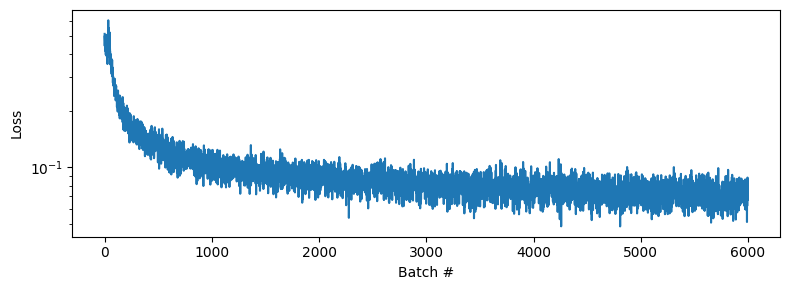

done.


In [405]:
plot_training_log(log)

# save
weight_file = os.path.join("save/1N", "weights")
log_file = os.path.join("save/1N", "log.json")
cfg_file = os.path.join("save/1N", "cfg.json")
# save model weights
th.save(policy.state_dict(), weight_file)


# save training history (log)
with open(log_file, 'w') as file:
  json.dump(losses, file)


# save environment configuration dictionary
cfg = env.get_save_config()
with open(cfg_file, 'w') as file:
  json.dump(cfg, file)


print("done.")

Parameter containing:
tensor([[-1.,  0.]])
torch.Size([32, 16])
dict_keys(['states', 'action', 'noisy action', 'goal'])
dict_keys(['joint', 'cartesian', 'muscle', 'geometry', 'fingertip'])
torch.Size([32, 4, 6])


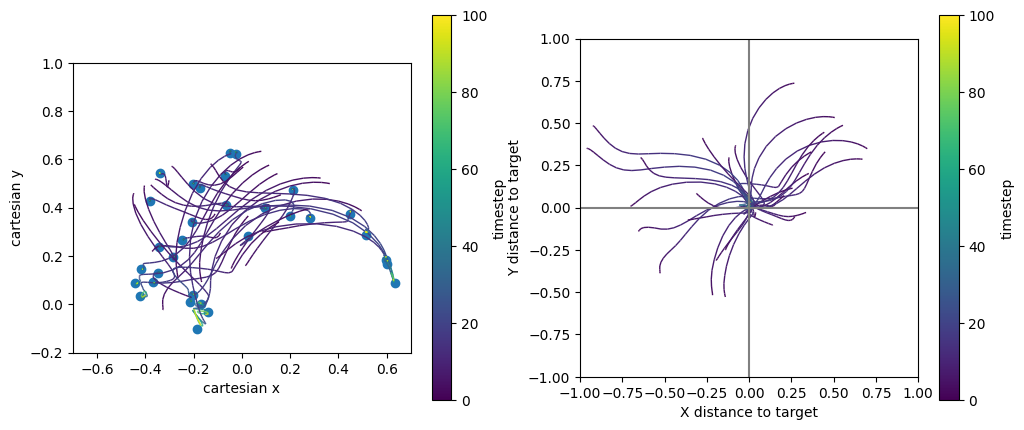

In [407]:
effector_force = RigidTendonArm26(muscle = MujocoHillMuscle())
effector_force.default_endpoint_load[0,0] = -1   
print(effector_force.default_endpoint_load)
env_force = mn.environment.RandomTargetReach(effector=effector_force, max_ep_duration=1.)
policy_10 = Policy(env_force.observation_space.shape[0], 128, env_force.n_muscles, device=device)

with open(cfg_file, 'r') as file:
    cfg = json.load(file)

with open(log_file, 'r') as file:
    loaded_training_log = json.load(file)

policy_10.load_state_dict(th.load(weight_file))

####

obs, info = env_force.reset(options={"batch_size": batch_size})

print(obs.shape)
print(info.keys())
print(info['states'].keys())
print(info['states']['geometry'].shape)

loss = []
for batch in range(n_batch):
    h = policy_10.init_hidden(batch_size=batch_size)
    xy = [info["states"]["fingertip"][:, None, :]]
    tg = [info["goal"][:, None, :]]
    terminated = False

    # simulate whole episode
    while not terminated:  # will run until `max_ep_duration` is reached
        action, h = policy_10(obs, h)
        obs, reward, terminated, truncated, info = env_force.step(action=action)

        xy.append(info["states"]["fingertip"][:, None, :])  # trajectories
        tg.append(info["goal"][:, None, :])  # targets

    # concatenate into a (batch_size, n_timesteps, xy) tensor
    xy = th.cat(xy, axis=1)
    tg = th.cat(tg, axis=1)
    loss.append(l2(xy, tg))
    break

plotor = mn.plotor.plot_pos_over_time
plot_simulations(xy=th.detach(xy), target_xy=th.detach(tg))

So when the constant IN force load is applied, the model still works.

In [ ]:
effector_force = RigidTendonArm26(muscle = MujocoHillMuscle())
effector_force.default_endpoint_load[0,0] = -1   
env_force = mn.environment.RandomTargetReach(effector=effector_force, max_ep_duration=1.)

effector = RigidTendonArm26(muscle = MujocoHillMuscle())
env = mn.environment.RandomTargetReach(effector=effector, max_ep_duration=1.)

# ------------------------------

policy_randomforce = Policy(env.observation_space.shape[0], 128, env.n_muscles, device=device)
optimizer = th.optim.Adam(policy.parameters(), lr=10**-3)

batch_size = 32
n_batch = 6000
losses = []
interval = 250

for batch in range(n_batch):
  # initialize batch
  h = policy_randomforce.init_hidden(batch_size=batch_size)
  obs, info = env.reset(options={"batch_size": batch_size})
  obs, info = env_force.reset(options={"batch_size": batch_size})
  terminated = False

  # initial positions and targets
  xy = [info["states"]["fingertip"][:, None, :]]
  tg = [info["goal"][:, None, :]]

  # simulate whole episode
  while not terminated:  # will run until `max_ep_duration` is reached
    action, h = policy_randomforce(obs, h)
    rand = np.random.rand(1)
    if rand >= 0.5:
      obs, reward, terminated, truncated, info = env.step(action=action)
    else:
      obs, reward, terminated, truncated, info = env_force.step(action=action)

    xy.append(info["states"]["fingertip"][:, None, :])  # trajectories
    tg.append(info["goal"][:, None, :])  # targets

  # concatenate into a (batch_size, n_timesteps, xy) tensor
  xy = th.cat(xy, axis=1)
  tg = th.cat(tg, axis=1)
  # break
  loss = l2(xy, tg)  # L1 loss on position
  
  # backward pass & update weights
  optimizer.zero_grad() 
  loss.backward()
  th.nn.utils.clip_grad_norm_(policy_randomforce.parameters(), max_norm=1.)  # important!
  optimizer.step()
  losses.append(loss.item())

  if (batch % interval == 0) and (batch != 0):
    print("Batch {}/{} Done, mean policy_10 loss: {}".format(batch, n_batch, sum(losses[-interval:])/interval))


Batch 250/6000 Done, mean policy_10 loss: 0.17981590694189073
Batch 500/6000 Done, mean policy_10 loss: 0.1807036517262459
Batch 750/6000 Done, mean policy_10 loss: 0.17858113604784012
